In [ ]:
import torch
import torch.nn as nn
from torchvision.models import vgg16_bn, VGG16_BN_Weights
import torch.nn.functional as F
import numpy as np
from torch.utils.data import Dataset, DataLoader, random_split
import os
from PIL import Image
from torchvision.transforms import Normalize, ToTensor, Compose
from matplotlib import pyplot as plt
import math
import pandas as pd

In [75]:
if torch.cuda.is_available():
    device=torch.device(type="cuda", index=1)
else:
    device=torch.device(type="cpu", index=0)
print(device)

cuda:1


Unique in Mask: [  0 255]
Image Shape: (584, 565, 3)
Mask Shape: (584, 565)


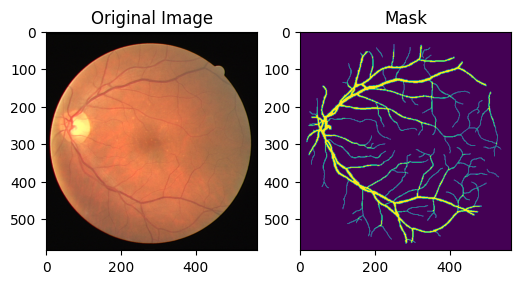

In [14]:
img = Image.open('/kaggle/input/vessel-segmentation/all/train/21_training.tif')
mask = Image.open('/kaggle/input/vessel-segmentation/all/train/21_manual1.gif')

print(f'Unique in Mask: {np.unique(mask)}')
print(f'Image Shape: {np.array(img).shape}\nMask Shape: {np.array(mask).shape}')
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plt.title("Original Image")
plt.imshow(img)
plt.subplot(1,2,2)
plt.title("Mask")
plt.imshow(mask)
plt.show()

In [15]:
def resizing(img_path, dim):
    img = Image.open(img_path)
    reshaped_img = img.resize((dim, dim), Image.NEAREST)
    return reshaped_img

In [33]:
class CustomTrainDataset(Dataset):
    def __init__(self, path, transform):
        super().__init__()
        self.path = path
        self.transform = transform
        _, _, self.filepaths = next(os.walk(path))
        self.length = int(len(self.filepaths) / 2) - 4
    def __len__(self):
        return self.length
    def __getitem__(self, idx):
        idx = idx + 21
        path = self.path + str(idx) + '_training.tif'
        img = resizing(path, 512)
        img = self.transform(img)

        path = self.path + str(idx) + "_manual1.gif"
        mask = resizing(path, 512)
        mask = np.array(mask)
        mask = torch.from_numpy(mask).type(torch.long)
        mask[mask==255] = 1
        return img, mask


class CustomValDataset(Dataset):
    def __init__(self, path, transform):
        super().__init__()
        self.path = path
        self.transform = transform
        _, _, self.filepaths = next(os.walk(path))
        self.length = int(len(self.filepaths) / 2) - 16
    def __len__(self):
        return self.length
    def __getitem__(self, idx):
        idx = idx + 37
        path = self.path + str(idx) + '_training.tif'
        img = resizing(path, 512)
        img = self.transform(img)

        path = self.path + str(idx) + "_manual1.gif"
        mask = resizing(path, 512)
        mask = np.array(mask)
        mask = torch.from_numpy(mask).type(torch.long)
        mask[mask==255] = 1
        return img, mask

In [37]:
transform = Compose([
    ToTensor(), 
    Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])
])
train_dataset = CustomTrainDataset("/kaggle/input/vessel-segmentation/all/train/", transform)
val_dataset = CustomValDataset("/kaggle/input/vessel-segmentation/all/train/", transform)

batch_size=4

train_dl = DataLoader(dataset=train_dataset,batch_size=batch_size,shuffle=True)
val_dl = DataLoader(dataset=val_dataset,batch_size=batch_size)

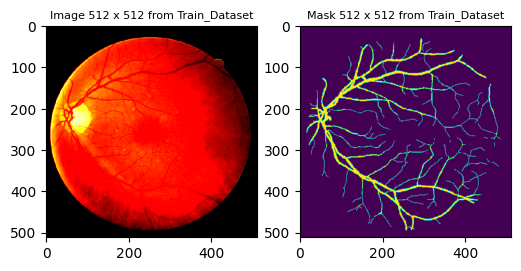

In [42]:
img, mask = train_dataset[0]
plt.figure(figsize=(6, 3))
plt.subplot(1,2,1)
plt.title("Image 512 x 512 from Train_Dataset", fontsize=8)
plt.imshow(torch.permute(img,(1,2,0)))

plt.subplot(1,2,2)
plt.title("Mask 512 x 512 from Train_Dataset", fontsize=8)
plt.imshow(mask)
plt.show()

In [43]:
class UNET(nn.Module):
    def __init__(self, encoder, bottleneck, decoder):
        super().__init__()
        self.encoder = encoder
        self.bottleneck = bottleneck
        self.decoder = decoder
    def forward(self,x):
        enc_ftrs_out = self.encoder(x)
        bn_out = self.bottleneck(enc_ftrs_out[-1])
        logits = self.decoder(bn_out, enc_ftrs_out)
        return logits

In [46]:
class Encoder(nn.Module):
    def __init__(self, model):
        super().__init__()
        self.encoder = model
    
    def forward(self,x):
        enc_ftrs_out=[]
        for layer in self.encoder.features:
                x = layer(x)
                enc_ftrs_out.append(x)          
        return enc_ftrs_out

In [61]:
class BottleNeck(nn.Sequential):
    def __init__(self):
        conv1=nn.Conv2d(in_channels=512,out_channels=2048, kernel_size=3,padding=1)
        bn1=nn.BatchNorm2d(num_features=2048)
        rl1=nn.ReLU()
        conv2=nn.Conv2d(in_channels=2048,out_channels=2048, kernel_size=3,padding=1)
        bn2=nn.BatchNorm2d(num_features=2048)
        rl2=nn.ReLU()
        conv3=nn.Conv2d(in_channels=2048,out_channels=1024, kernel_size=3,padding=1)
        bn3=nn.BatchNorm2d(num_features=1024)
        rl3=nn.ReLU()
        super().__init__(conv1, bn1, rl1, conv2, bn2, rl2, conv3, bn3, rl3)

In [ ]:
class Decoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.rl=nn.ReLU()
                        
        self.conv5_up=nn.Conv2d(in_channels=1024,out_channels=512, kernel_size=3,padding=1)
        self.conv5_1=nn.Conv2d(in_channels=1024,out_channels=512, kernel_size=3,padding=1)
        self.bn5_1=nn.BatchNorm2d(num_features=512)
        self.conv5_2=nn.Conv2d(in_channels=512,out_channels=512, kernel_size=3,padding=1)
        self.bn5_2=nn.BatchNorm2d(num_features=512)
        self.conv5_3=nn.Conv2d(in_channels=512,out_channels=512, kernel_size=3,padding=1)
        self.bn5_3=nn.BatchNorm2d(num_features=512)
        
        self.conv4_up=nn.Conv2d(in_channels=512,out_channels=512, kernel_size=3,padding=1)
        self.conv4_1=nn.Conv2d(in_channels=1024,out_channels=512, kernel_size=3,padding=1)
        self.bn4_1=nn.BatchNorm2d(num_features=512)
        self.conv4_2=nn.Conv2d(in_channels=512,out_channels=512, kernel_size=3,padding=1)
        self.bn4_2=nn.BatchNorm2d(num_features=512)
        self.conv4_3=nn.Conv2d(in_channels=512,out_channels=512, kernel_size=3,padding=1)
        self.bn4_3=nn.BatchNorm2d(num_features=512)
        
        self.conv3_up=nn.Conv2d(in_channels=512,out_channels=256, kernel_size=3,padding=1)
        self.conv3_1=nn.Conv2d(in_channels=512,out_channels=256, kernel_size=3,padding=1)
        self.bn3_1=nn.BatchNorm2d(num_features=256)
        self.conv3_2=nn.Conv2d(in_channels=256,out_channels=256, kernel_size=3,padding=1)
        self.bn3_2=nn.BatchNorm2d(num_features=256)
        self.conv3_3=nn.Conv2d(in_channels=256,out_channels=256, kernel_size=3,padding=1)
        self.bn3_3=nn.BatchNorm2d(num_features=256)
        
        self.conv2_up=nn.Conv2d(in_channels=256,out_channels=128, kernel_size=3,padding=1)
        self.conv2_1=nn.Conv2d(in_channels=256,out_channels=128, kernel_size=3,padding=1)
        self.bn2_1=nn.BatchNorm2d(num_features=128)
        self.conv2_2=nn.Conv2d(in_channels=128,out_channels=128, kernel_size=3,padding=1)
        self.bn2_2=nn.BatchNorm2d(num_features=128)
        
        self.conv1_up=nn.Conv2d(in_channels=128,out_channels=64, kernel_size=3,padding=1)
        self.conv1_1=nn.Conv2d(in_channels=128,out_channels=64, kernel_size=3,padding=1)
        self.bn1_1=nn.BatchNorm2d(num_features=64)
        self.conv1_2=nn.Conv2d(in_channels=64,out_channels=64, kernel_size=3,padding=1)
        self.bn1_2=nn.BatchNorm2d(num_features=64)
        
        self.convfinal=nn.Conv2d(in_channels=64,out_channels=2,kernel_size=1)
    
    def forward(self,x, enc_ftrs_out):
        x=F.interpolate(x,scale_factor=2, mode="nearest")
        x=self.conv5_up(x)
        x=self.rl(x)
        x=torch.cat((x,enc_ftrs_out[42]),dim=1)
        x=self.conv5_1(x)
        x=self.bn5_1(x)
        x=self.rl(x)
        x=self.conv5_2(x)
        x=self.bn5_2(x)
        x=self.rl(x)
        x=self.conv5_3(x)
        x=self.bn5_3(x)
        x=self.rl(x)
        
        x=F.interpolate(x,scale_factor=2, mode="nearest")
        x=self.conv4_up(x)
        x=self.rl(x)
        x=torch.cat((x,enc_ftrs_out[32]),dim=1)
        x=self.conv4_1(x)
        x=self.bn4_1(x)
        x=self.rl(x)
        x=self.conv4_2(x)
        x=self.bn4_2(x)
        x=self.rl(x)
        x=self.conv4_3(x)
        x=self.bn4_3(x)
        x=self.rl(x)
        
        x=F.interpolate(x,scale_factor=2, mode="nearest")
        x=self.conv3_up(x)
        x=self.rl(x)
        x=torch.cat((x,enc_ftrs_out[22]),dim=1)
        x=self.conv3_1(x)
        x=self.bn3_1(x)
        x=self.rl(x)
        x=self.conv3_2(x)
        x=self.bn3_2(x)
        x=self.rl(x)
        x=self.conv3_3(x)
        x=self.bn3_3(x)
        x=self.rl(x)
        
        x=F.interpolate(x,scale_factor=2, mode="nearest")
        x=self.conv2_up(x)
        x=self.rl(x)
        x=torch.cat((x,enc_ftrs_out[12]),dim=1)
        x=self.conv2_1(x)
        x=self.bn2_1(x)
        x=self.rl(x)
        x=self.conv2_2(x)
        x=self.bn2_2(x)
        x=self.rl(x)
        
        x=F.interpolate(x,scale_factor=2, mode="nearest")
        x=self.conv1_up(x)
        x=self.rl(x)
        x=torch.cat((x,enc_ftrs_out[5]),dim=1)
        x=self.conv1_1(x)
        x=self.bn1_1(x)
        x=self.rl(x)
        x=self.conv1_2(x)
        x=self.bn1_2(x)
        x=self.rl(x)
        
        logits=self.convfinal(x)
        
        return logits
        

In [54]:
def train_one_epoch(dataloader, model,loss_fn, optimizer):
    model.train()
    track_loss=0
    XintY=0
    X=0
    Y=0
    for i, (imgs, masks) in enumerate(dataloader):
        imgs=imgs.to(device)
        masks=masks.to(device)
        
        preds=model(imgs)
        
        loss=loss_fn(preds,masks)
        
        track_loss+=loss.item()
        
        predclass=torch.argmax(preds,dim=1)
        
        Y+=predclass.sum().item()
        X+=masks.sum().item()
        
        
        predclass[predclass==0]=2
        
        XintY+=(predclass==masks).type(torch.float).sum().item()
        
        
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        running_loss=round(track_loss/(i+1),2)
        running_dice_coef=round(((2*XintY)/(X+Y)),2)
        
        print("Training Batch", i+1,":","/",len(dataloader), "Running Loss:",running_loss, "Running Dice_Coef:",running_dice_coef)
            
    epoch_loss=running_loss
    epoch_dice_coef=running_dice_coef    
    return epoch_loss, epoch_dice_coef

In [95]:
def val_one_epoch(dataloader, model,loss_fn):
    model.eval()
    track_loss=0
    XintY=0
    X=0
    Y=0
    with torch.no_grad():
        for i, (imgs, masks) in enumerate(dataloader):
            imgs=imgs.to(device)
            masks=masks.to(device)
            
            preds=model(imgs)
            
            loss=loss_fn(preds,masks)
            
            track_loss+=loss.item()
            
            predclass=torch.argmax(preds,dim=1)
            
            Y+=predclass.sum().item()
            X+=masks.sum().item()
            
            predclass[predclass==0]=2
            
            XintY+=(predclass==masks).type(torch.float).sum().item()
            
            

            running_loss=round(track_loss/(i+1),2)
            running_dice_coef=round(((2*XintY)/(X+Y)),2)
            
            print("Validation Batch", i+1,":","/",len(dataloader), "Running Loss:",running_loss, "Running Dice_Coef:",running_dice_coef)
            
    epoch_loss=running_loss
    epoch_dice_coef=running_dice_coef    
    return epoch_loss, epoch_dice_coef

In [94]:
vgg16_model = vgg16_bn(weights=VGG16_BN_Weights.DEFAULT)
for param in vgg16_model.features.parameters():
    param.requires_grad = False
encoder=Encoder(vgg16_model).to(device)
bottleneck=BottleNeck().to(device)
decoder=Decoder().to(device)

model=UNET(encoder,bottleneck, decoder).to(device)

loss_fn=nn.CrossEntropyLoss()
lr=0.001
optimizer=torch.optim.Adam(params=model.parameters(), lr=lr)
n_epochs=100

In [96]:
for i in range(n_epochs):
    print("Epoch No:",i+1)
    train_epoch_loss, train_epoch_dice_coef=train_one_epoch(train_dl,model,loss_fn,optimizer)
    print("Training Epoch Loss:", train_epoch_loss, "Training Epoch Dice_Coef:", train_epoch_dice_coef)
    val_epoch_loss, val_epoch_dice_coef=val_one_epoch(val_dl,model,loss_fn)
    print("Validation Epoch Loss:", val_epoch_loss, "Validation Epoch Dice_Coef:", val_epoch_dice_coef)
    print("--------------------------------------------------")

Epoch No: 1
Training Batch 1 : / 4 Running Loss: 0.74 Running Dice_Coef: 0.16
Training Batch 2 : / 4 Running Loss: 0.71 Running Dice_Coef: 0.23
Training Batch 3 : / 4 Running Loss: 0.66 Running Dice_Coef: 0.28
Training Batch 4 : / 4 Running Loss: 0.62 Running Dice_Coef: 0.32
Training Epoch Loss: 0.62 Training Epoch Dice_Coef: 0.32
Validation Batch 1 : / 1 Running Loss: 28.16 Running Dice_Coef: 0.16
Validation Epoch Loss: 28.16 Validation Epoch Dice_Coef: 0.16
--------------------------------------------------
Epoch No: 2
Training Batch 1 : / 4 Running Loss: 0.44 Running Dice_Coef: 0.54
Training Batch 2 : / 4 Running Loss: 0.42 Running Dice_Coef: 0.6
Training Batch 3 : / 4 Running Loss: 0.4 Running Dice_Coef: 0.62
Training Batch 4 : / 4 Running Loss: 0.38 Running Dice_Coef: 0.63
Training Epoch Loss: 0.38 Training Epoch Dice_Coef: 0.63
Validation Batch 1 : / 1 Running Loss: 184.1 Running Dice_Coef: 0.16
Validation Epoch Loss: 184.1 Validation Epoch Dice_Coef: 0.16
-----------------------

In [97]:
def plotres(img,pred,mask=None):
    img[0,:,:]=img[0,:,:]*0.229 + 0.485
    img[1,:,:]=img[1,:,:]*0.224 + 0.456
    img[2,:,:]=img[2,:,:]*0.225 + 0.406
    if mask!=None:
        print("Image Shape:",img.shape,"Mask Shape:", mask.shape, "Pred Shape:",pred.shape, "Image dtype", img.dtype, "Mask dtype",mask.dtype, "Pred dtype",pred.dtype)
        print("Mask Unique:",mask.unique())
    else:
        print("Image Shape:",img.shape, "Pred Shape:", pred.shape, "Image dtype:",img.dtype, "Pred dtype:",pred.dtype)
    
    print("Pred Unique:",pred.unique())
    
    plt.figure(figsize=(6, 3))
    
    plt.subplot(1,3,1)
    plt.title("Original Image 512 x 512", fontsize=8)
    plt.imshow(torch.permute(img.cpu(),(1,2,0)))
    
    if mask!=None:
        plt.subplot(1,3,2)
        plt.title("Mask Image  512 x 512", fontsize=8)
        plt.imshow(mask.cpu())
    
    plt.subplot(1,3,3)
    plt.title("Predicted Image  512 x 512", fontsize=8)
    plt.imshow(pred.cpu())
    plt.show()

Validation Dice Coef: 0.81
Image Shape: torch.Size([3, 512, 512]) Mask Shape: torch.Size([512, 512]) Pred Shape: torch.Size([512, 512]) Image dtype torch.float32 Mask dtype torch.int64 Pred dtype torch.int64
Mask Unique: tensor([0, 1], device='cuda:1')
Pred Unique: tensor([0, 1], device='cuda:1')


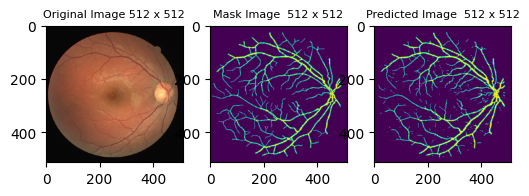

Image Shape: torch.Size([3, 512, 512]) Mask Shape: torch.Size([512, 512]) Pred Shape: torch.Size([512, 512]) Image dtype torch.float32 Mask dtype torch.int64 Pred dtype torch.int64
Mask Unique: tensor([0, 1], device='cuda:1')
Pred Unique: tensor([0, 1], device='cuda:1')


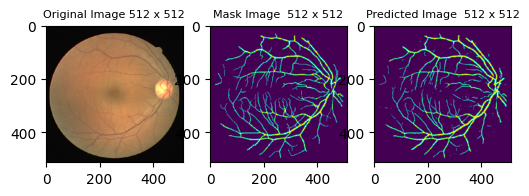

Image Shape: torch.Size([3, 512, 512]) Mask Shape: torch.Size([512, 512]) Pred Shape: torch.Size([512, 512]) Image dtype torch.float32 Mask dtype torch.int64 Pred dtype torch.int64
Mask Unique: tensor([0, 1], device='cuda:1')
Pred Unique: tensor([0, 1], device='cuda:1')


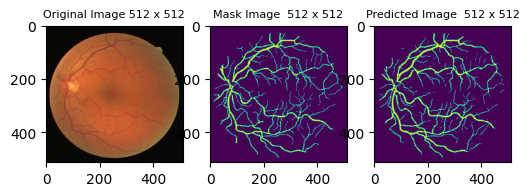

Image Shape: torch.Size([3, 512, 512]) Mask Shape: torch.Size([512, 512]) Pred Shape: torch.Size([512, 512]) Image dtype torch.float32 Mask dtype torch.int64 Pred dtype torch.int64
Mask Unique: tensor([0, 1], device='cuda:1')
Pred Unique: tensor([0, 1], device='cuda:1')


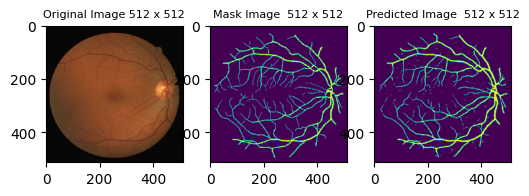

In [98]:
imgs, masks=next(iter(val_dl))
model.eval()

imgs=imgs.to(device)
masks=masks.to(device)

with torch.no_grad():
    preds=model(imgs)
    
    predclass=torch.argmax(preds,dim=1)
            
    Y=predclass.sum().item()
    X=masks.sum().item()
            
    predclass[predclass==0]=2
    
    XintY=(predclass==masks).type(torch.float).sum().item()
    
    dice_coef=round((2*XintY)/(X+Y),2)
    
    
print("Validation Dice Coef:",dice_coef)

predclass[predclass==2]=0
plotres(imgs[0],predclass[0],masks[0])
plotres(imgs[1],predclass[1],masks[1])
plotres(imgs[2],predclass[2],masks[2])
plotres(imgs[3],predclass[3],masks[3])

In [99]:
class CustomTestDataset(Dataset):
    def __init__(self, path, transform):
        super().__init__()
        self.path = path
        self.transform = transform
        _, _, self.filepaths = next(os.walk(path))
        self.length = len(self.filepaths)
    def __len__(self):
        return self.length
    def __getitem__(self, idx):
        idx = idx + 1
        if idx <= 9:
            path=self.path + "0" + str(idx) + "_test.tif"
        else:
            path=self.path + str(idx) + "_test.tif"
        img = resizing(path, 512)
        img = self.transform(img)

        return img

In [100]:
test_dataset = CustomTestDataset('/kaggle/input/vessel-segmentation/all/test/', transform)
batch_size = 2
test_dl = DataLoader(dataset=test_dataset,batch_size=batch_size)

In [101]:
def eval_one_epoch(dataloader, model):
    model.eval()
    outputs=[]
    for i, imgs in enumerate(dataloader):
        imgs=imgs.to(device)
        preds=model(imgs)
               
        with torch.no_grad():
            for i in range(preds.shape[0]):
                pred=preds[i,:,:,:]
                pred=torch.argmax(pred,dim=0).cpu()
                
                plotres(imgs[i],pred)
                
                predf=pred.flatten()
                
                pixelidx=np.where(predf==1)[0]+1
                
                run_lengths=[]
                
                for pxid in pixelidx:
                    if len(run_lengths)==0:
                        run_lengths.extend((pxid,1))
                    elif pxid>prev+1:
                        run_lengths.extend((pxid,1))
                    else:
                        run_lengths[-1]+=1
                    prev=pxid
                
                output = ' '.join([str(r) for r in run_lengths])
                
                outputs.append(output)
    return outputs

Image Shape: torch.Size([3, 512, 512]) Pred Shape: torch.Size([512, 512]) Image dtype: torch.float32 Pred dtype: torch.int64
Pred Unique: tensor([0, 1])


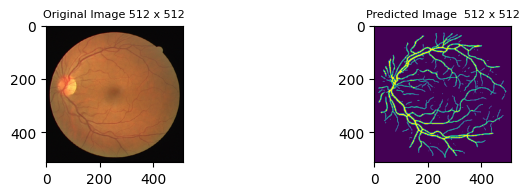

Image Shape: torch.Size([3, 512, 512]) Pred Shape: torch.Size([512, 512]) Image dtype: torch.float32 Pred dtype: torch.int64
Pred Unique: tensor([0, 1])


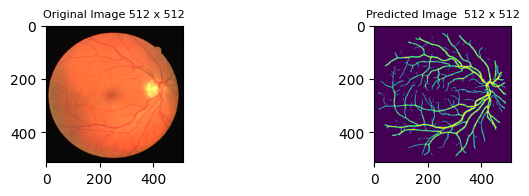

Image Shape: torch.Size([3, 512, 512]) Pred Shape: torch.Size([512, 512]) Image dtype: torch.float32 Pred dtype: torch.int64
Pred Unique: tensor([0, 1])


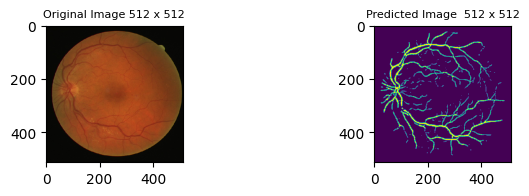

Image Shape: torch.Size([3, 512, 512]) Pred Shape: torch.Size([512, 512]) Image dtype: torch.float32 Pred dtype: torch.int64
Pred Unique: tensor([0, 1])


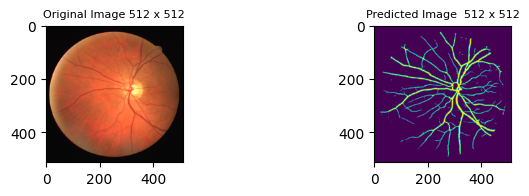

Image Shape: torch.Size([3, 512, 512]) Pred Shape: torch.Size([512, 512]) Image dtype: torch.float32 Pred dtype: torch.int64
Pred Unique: tensor([0, 1])


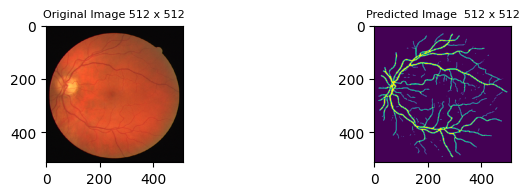

Image Shape: torch.Size([3, 512, 512]) Pred Shape: torch.Size([512, 512]) Image dtype: torch.float32 Pred dtype: torch.int64
Pred Unique: tensor([0, 1])


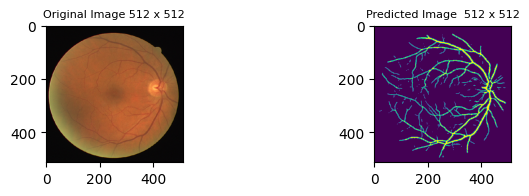

Image Shape: torch.Size([3, 512, 512]) Pred Shape: torch.Size([512, 512]) Image dtype: torch.float32 Pred dtype: torch.int64
Pred Unique: tensor([0, 1])


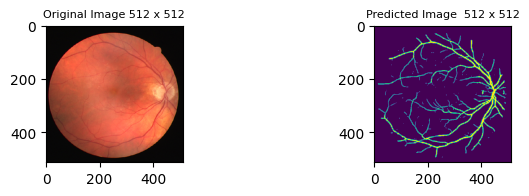

Image Shape: torch.Size([3, 512, 512]) Pred Shape: torch.Size([512, 512]) Image dtype: torch.float32 Pred dtype: torch.int64
Pred Unique: tensor([0, 1])


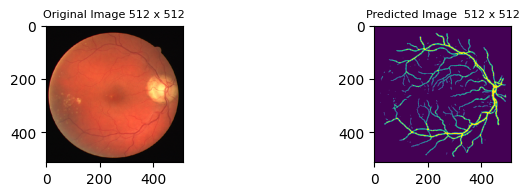

Image Shape: torch.Size([3, 512, 512]) Pred Shape: torch.Size([512, 512]) Image dtype: torch.float32 Pred dtype: torch.int64
Pred Unique: tensor([0, 1])


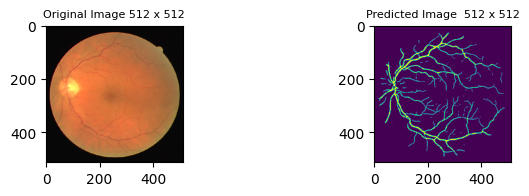

Image Shape: torch.Size([3, 512, 512]) Pred Shape: torch.Size([512, 512]) Image dtype: torch.float32 Pred dtype: torch.int64
Pred Unique: tensor([0, 1])


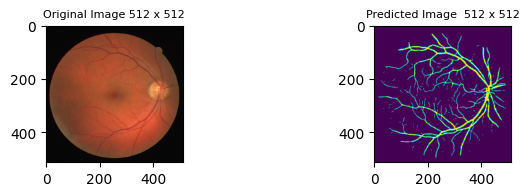

Image Shape: torch.Size([3, 512, 512]) Pred Shape: torch.Size([512, 512]) Image dtype: torch.float32 Pred dtype: torch.int64
Pred Unique: tensor([0, 1])


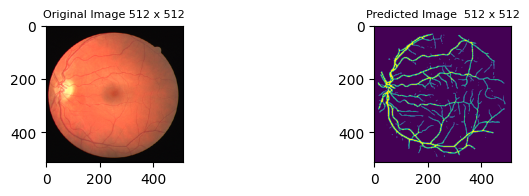

Image Shape: torch.Size([3, 512, 512]) Pred Shape: torch.Size([512, 512]) Image dtype: torch.float32 Pred dtype: torch.int64
Pred Unique: tensor([0, 1])


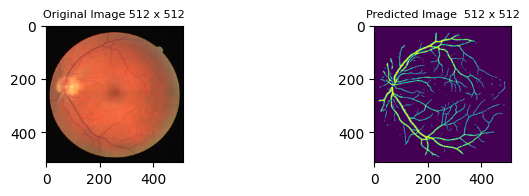

Image Shape: torch.Size([3, 512, 512]) Pred Shape: torch.Size([512, 512]) Image dtype: torch.float32 Pred dtype: torch.int64
Pred Unique: tensor([0, 1])


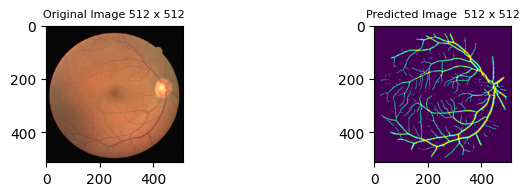

Image Shape: torch.Size([3, 512, 512]) Pred Shape: torch.Size([512, 512]) Image dtype: torch.float32 Pred dtype: torch.int64
Pred Unique: tensor([0, 1])


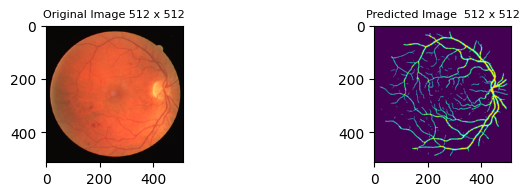

Image Shape: torch.Size([3, 512, 512]) Pred Shape: torch.Size([512, 512]) Image dtype: torch.float32 Pred dtype: torch.int64
Pred Unique: tensor([0, 1])


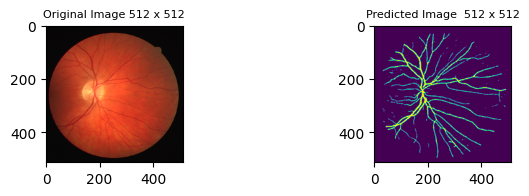

Image Shape: torch.Size([3, 512, 512]) Pred Shape: torch.Size([512, 512]) Image dtype: torch.float32 Pred dtype: torch.int64
Pred Unique: tensor([0, 1])


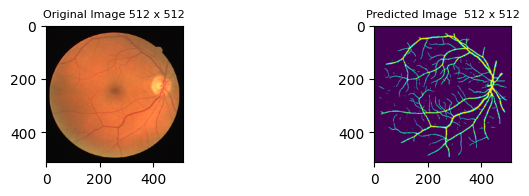

Image Shape: torch.Size([3, 512, 512]) Pred Shape: torch.Size([512, 512]) Image dtype: torch.float32 Pred dtype: torch.int64
Pred Unique: tensor([0, 1])


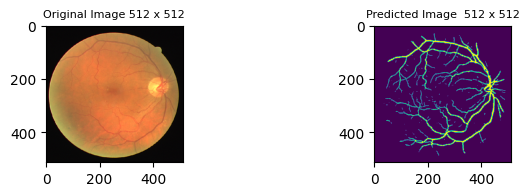

Image Shape: torch.Size([3, 512, 512]) Pred Shape: torch.Size([512, 512]) Image dtype: torch.float32 Pred dtype: torch.int64
Pred Unique: tensor([0, 1])


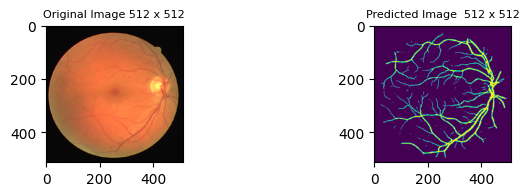

Image Shape: torch.Size([3, 512, 512]) Pred Shape: torch.Size([512, 512]) Image dtype: torch.float32 Pred dtype: torch.int64
Pred Unique: tensor([0, 1])


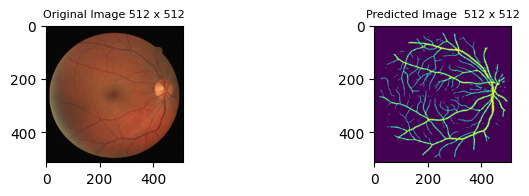

Image Shape: torch.Size([3, 512, 512]) Pred Shape: torch.Size([512, 512]) Image dtype: torch.float32 Pred dtype: torch.int64
Pred Unique: tensor([0, 1])


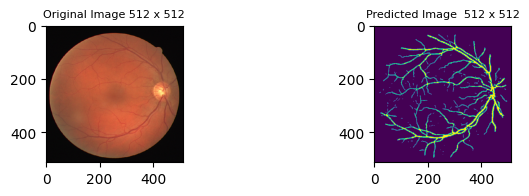

,Id,Predicted
0,0,15109 2 15621 3 16104 4 16133 3 16164 3 16616 ...
1,1,15103 2 15616 2 16128 4 16641 7 16659 1 17154 ...
2,2,13070 6 13579 7 14089 7 14113 1 14600 6 14631 ...
3,3,13560 3 14071 5 14584 4 15096 5 15608 5 15665 ...
4,4,16642 2 17153 3 17188 3 17664 3 17699 5 18174 ...
5,5,17190 2 17701 5 18176 1 18213 7 18726 7 19142 ...
6,6,16143 2 16612 8 16655 2 17125 7 17168 2 17639 ...
7,7,15592 3 16104 4 16617 5 16656 4 17130 5 17168 ...
8,8,15126 3 15603 1 15636 5 16115 2 16147 6 16628 ...
9,9,16128 2 16640 2 17113 3 17152 3 17624 5 17664 ...


In [102]:
outputs = eval_one_epoch(test_dl,model)
df = pd.DataFrame(columns=['Id','Predicted'])   
df['Id'] = [str(i) for i in range(20)]
df['Predicted'] = outputs
df.to_csv("submission.csv", index=None)
df